In [1]:
import pickle
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score, auc
from sklearn.inspection import permutation_importance

from scipy.spatial import distance
from scipy.cluster import hierarchy
import umap
import umap.plot
import networkx as nx
import sys
sys.path.insert(1, '../scripts_other/')
import cs_umap_plot

import matplotlib.pyplot as plt
from bokeh.plotting import show, save, output_notebook, output_file
import seaborn as sns

import time
import datetime

print(datetime.datetime.now())

2023-05-09 15:40:30.049621


In [2]:
path_data = '../data/d20220201/'

# INPUTS
fn_finalSave = path_data + 'featuresAndMeta_s20220720.p'

# OUTPUTS
fn_featureImp = path_data + 'featureImportance_binaryAll_s20220704.p'

fn_featureGrps_csv_supp = '../supplementaryFiles/csv_featureGrps_s20211031.csv'
fn_featureImportance_supp = '../supplementaryFiles/csv_featureImportance_s20211031.csv'

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.size'] = 10
plt.rcParams['figure.autolayout']=False

In [3]:
with open(fn_finalSave, "rb") as input_file:
    dict_data = pickle.load(input_file)

dict_data.keys()

dict_keys(['df_rawFeatures_training', 'df_rawFeatures_validation', 'dict_normalizationFactors', 'df_zscoreFeatures_training', 'df_zscoreFeatures_validation', 'df_metadata', 'umap_raw', 'umap_zscore'])

## load data

In [ ]:
# define current data
currFeatures = dict_data['df_zscoreFeatures_training']
tempMeta = dict_data['df_metadata']
currMeta = tempMeta[tempMeta.index.isin(currFeatures.index)]
currMeta['hvpg_corrected'] = currMeta['hvpg_corrected'].fillna(0).astype(int)
currMeta['hvpg_toPredict'] = currMeta['hvpg_corrected'].apply(lambda x: 0 if x < 10 else 1)

toPredict = currMeta['hvpg_toPredict']

display(currFeatures)
#display(currMeta)

## Calculate importances

In [5]:
## use feature permutation to identify most important feature of each cluster
train_features = dict_data['df_zscoreFeatures_training']
train_labels = currMeta['hvpg_toPredict']

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_features, train_labels); 

start_time = time.time()
result = permutation_importance(
    rf, train_features, train_labels, n_repeats=10, random_state=42, n_jobs=-1
)
elapsed_time = (time.time() - start_time) / 60
print(f"Elapsed time to compute the importances: {elapsed_time:.1f} minutes")

forest_importances = pd.Series(result.importances_mean, index=train_features.columns)

Elapsed time to compute the importances: 163.1 minutes


In [9]:
# save feature importances
pickle.dump(forest_importances, open(fn_featureImp, 'wb'))
forest_importances.to_csv(fn_featureImportance_supp)


## Grid search

Elapsed time to compute the linkages: 16.524 seconds


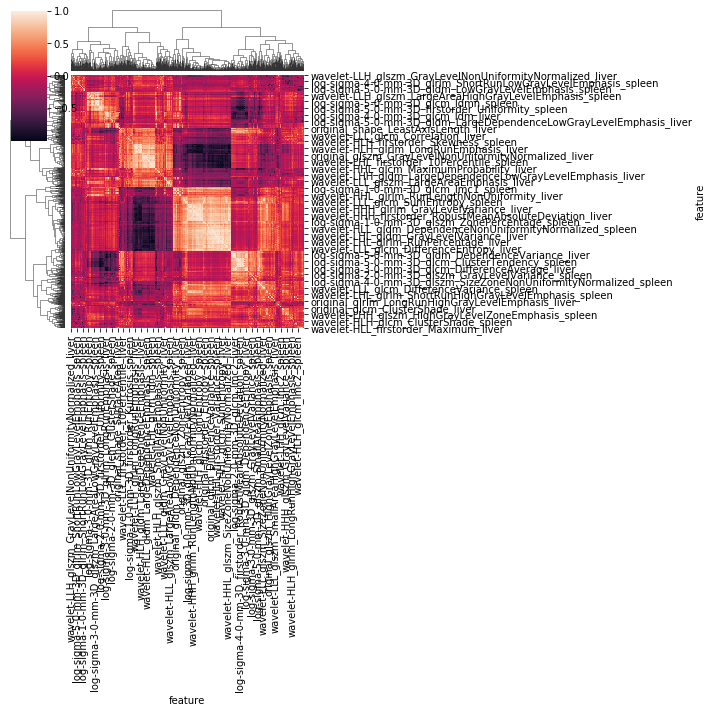

In [10]:
## identify redundant features

start_time = time.time()

# retrieve clusters using fcluster 
df_featcorr = currFeatures.astype(float).corr(method='pearson')
d = hierarchy.distance.pdist(df_featcorr)
L = hierarchy.linkage(d, method='complete')

currPlt = sns.clustermap(df_featcorr, row_linkage=L, col_linkage=L)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the linkages: {elapsed_time:.3f} seconds")

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LR: 0.874913 (0.035839)
LDA: 0.635700 (0.070232)
KNN: 0.845714 (0.075902)
DTC: 0.698918 (0.082209)
GNB: 0.823488 (0.074047)
SVM: 0.902071 (0.042504)
RF: 0.889578 (0.050780)


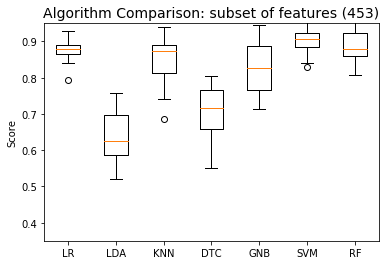

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LR: 0.871883 (0.035175)
LDA: 0.619387 (0.055608)
KNN: 0.862749 (0.068749)
DTC: 0.698203 (0.070408)
GNB: 0.833355 (0.066535)
SVM: 0.903312 (0.038465)
RF: 0.894044 (0.044152)


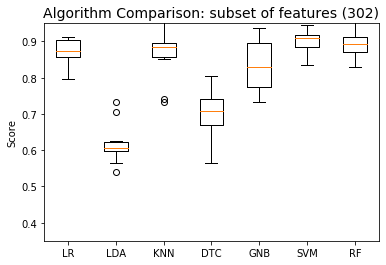

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR: 0.873391 (0.030225)
LDA: 0.770022 (0.090442)
KNN: 0.863900 (0.074983)
DTC: 0.726710 (0.040564)
GNB: 0.842114 (0.066051)
SVM: 0.911948 (0.036752)
RF: 0.899037 (0.045080)


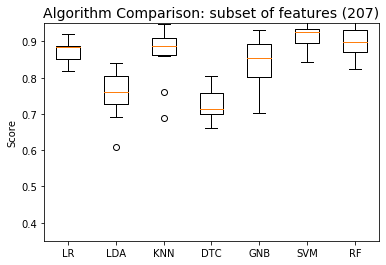

LR: 0.877388 (0.041365)
LDA: 0.823983 (0.070846)
KNN: 0.861692 (0.078318)
DTC: 0.734048 (0.058672)
GNB: 0.842857 (0.070903)
SVM: 0.907814 (0.038738)
RF: 0.900898 (0.052122)


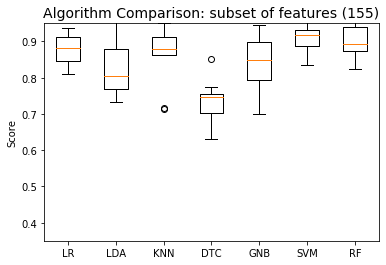

LR: 0.891328 (0.054711)
LDA: 0.868297 (0.052648)
KNN: 0.852482 (0.067533)
DTC: 0.754805 (0.075586)
GNB: 0.844574 (0.083289)
SVM: 0.915375 (0.038904)
RF: 0.908106 (0.036158)


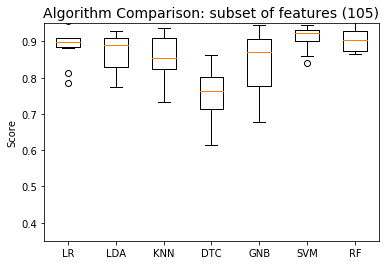

LR: 0.877778 (0.060967)
LDA: 0.866905 (0.053773)
KNN: 0.869001 (0.058390)
DTC: 0.766991 (0.079360)
GNB: 0.844517 (0.091547)
SVM: 0.919704 (0.039963)
RF: 0.911259 (0.048128)


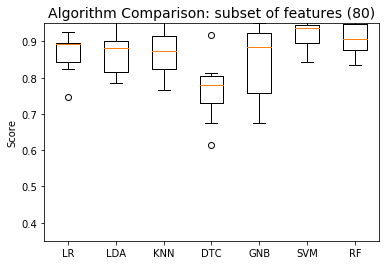

LR: 0.883434 (0.067604)
LDA: 0.883016 (0.061499)
KNN: 0.869722 (0.078986)
DTC: 0.777706 (0.059877)
GNB: 0.861100 (0.075519)
SVM: 0.911667 (0.048856)
RF: 0.901378 (0.048290)


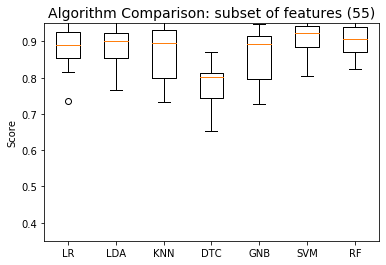

LR: 0.895072 (0.073372)
LDA: 0.889820 (0.056791)
KNN: 0.853665 (0.070689)
DTC: 0.764502 (0.079787)
GNB: 0.862287 (0.068222)
SVM: 0.910700 (0.050200)
RF: 0.898424 (0.045208)


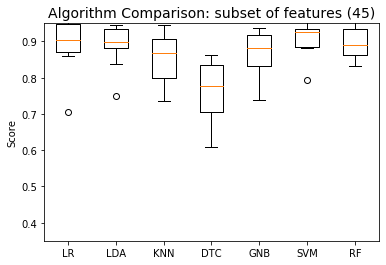

LR: 0.883817 (0.069121)
LDA: 0.884654 (0.056684)
KNN: 0.865617 (0.069713)
DTC: 0.795455 (0.077223)
GNB: 0.863755 (0.072497)
SVM: 0.911501 (0.052348)
RF: 0.901259 (0.043736)


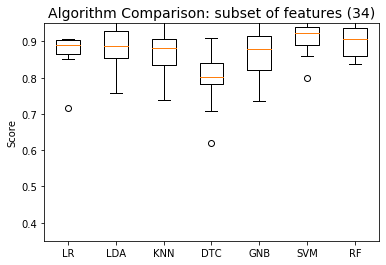

In [11]:
dvalues = [0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3]
numClusters = []
featCluster_collection = {}

for eaValue in dvalues:
    # initiate dictionary to store stuff
    featCluster_collection[eaValue] = {}
    # cahnge eaValue to retrieve more stringent or relaxed clusters (fewer clusters, increase number)
    clusters = hierarchy.fcluster(L, eaValue*d.max(), 'distance')
    numClusters.append(len(set(clusters)))
    featCluster_collection[eaValue]['length'] = len(set(clusters))
    
    # make cluster dictionary
    featCluster_dict = defaultdict(list)
    for i,cluster in enumerate(clusters):
        featCluster_dict[cluster].append(df_featcorr.index[i])
        
    featCluster_collection[eaValue]['clusters'] = featCluster_dict
    
    # for each cluster, check which feature is most important, and keep it for downstream model
    feat2keep = []
    featClusterOrder = []
    for eaCluster in featCluster_dict:
        currFeature_i = [currFeatures.columns.get_loc(c) for c in featCluster_dict[eaCluster]]
        currImportances = [forest_importances[c] for c in currFeature_i]
        toKeep_i = currFeature_i[currImportances.index(max(currImportances))]
        feat2keep.append(currFeatures.columns[toKeep_i])
        featClusterOrder.append(eaCluster)    
    featCluster_collection[eaValue]['feat2keep'] = feat2keep
    featCluster_collection[eaValue]['featClusterOrder'] = featClusterOrder
    
    # save features to keep
    features = currFeatures[feat2keep]
    labels = toPredict

    X_train, X_validation, Y_train, Y_validation = train_test_split(features, labels, test_size=0.20, random_state=1, shuffle=True)
    # Spot Check Algorithms
    models = []
    models.append(('LR', LogisticRegression()))#(solver='liblinear', multi_class='ovr')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('DTC', DecisionTreeClassifier()))
    models.append(('GNB', GaussianNB()))
    models.append(('SVM', SVC(gamma='auto')))
    models.append(('RF', RandomForestClassifier(n_estimators=100)))
    # evaluate each model in turn
    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='roc_auc')
        results.append(cv_results)
        names.append(name)
        print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    # Compare Algorithms
    plt.boxplot(results, labels=names)
    plt.ylabel('Score')
    plt.ylim([0.35, 0.95])
    plt.title('Algorithm Comparison: subset of features (' + str(len(featCluster_dict)) + ')')
    plt.show()

In [12]:
print('total # of features:')
print(len(clusters))
print('# features used for model training:')
print(numClusters)

total # of features:
2436
# features used for model training:
[453, 302, 207, 155, 105, 80, 55, 45, 34]


In [13]:
print(featCluster_collection.keys())
print(featCluster_collection[0.1].keys())

dict_keys([0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3])
dict_keys(['length', 'clusters', 'feat2keep', 'featClusterOrder'])


In [14]:
print(datetime.datetime.now())

2023-05-09 18:41:22.754034
